In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from itertools import permutations
import random
import math
from tqdm.auto import tqdm

/Users/nicolasnguyen/.pyenv/versions/3.10.4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Node:
    def __init__(self, depth, index, parent=None) -> None:
        self.depth = depth
        self.index = index
        self.parent = parent
        self.left = None
        self.right = None
        self.active = False
        self.mean_estimates = []
        self.proba = 0.0
        self.size = 1/(2**(self.depth-1))
    
    def subdivide(self):
        self.left = Node(self.depth + 1, 2 * self.index - 1, parent=self)
        self.right = Node(self.depth + 1, 2 * self.index, parent=self)

    def evict(self):
        self.active = False
        if self.left :
            self.left.evict()
        if self.right:
            self.right.evict()

    def contains(self, x):
        left = (self.index-1) / (2**(self.depth-1))
        right = (self.index) / (2 ** (self.depth-1))
        return left <= x <= right
    
    def get_parent(self, target_depth):
        """ 
        Enumerate the list of children of a given node
        """
        if target_depth >= self.depth :
            return None
        current = self
        while current and current.depth > target_depth:
            current = current.parent
        return current

    def get_descendants_at_depth(self, target_depth):
        if target_depth <= self.depth :
            return []
        result = []

        def helper(node):
            if node is None :
                return
            if node.depth == target_depth :
                result.append(node)
            elif node.depth < target_depth :
                helper(node.left)
                helper(node.right)
        helper(self)
        return result
    
    def get_active_children(self, target_depth):
        if target_depth <= self.depth :
            return []
        
        result = []

        def dfs(node):
            if node is None :
                return
            if node.depth == target_depth and node.active :
                result.append(node)
            elif node.depth < target_depth :
                dfs(node.left)
                dfs(node.right)
                
        dfs(self)
        return result
    
    def sample(self):
        """ Sample one action (i.e. number) in node """
        left = (self.index-1) / (2**(self.depth-1))
        right = (self.index) / (2 ** (self.depth-1))
        return random.uniform(left, right)


    def __repr__(self) -> str:
        return f"p={self.proba}, mean={self.mean_estimates}"

In [3]:
class Tree:

    def __init__(self, max_depth) -> None:
        self.max_depth = max_depth
        self.root = Node(1, 1)
        
        if max_depth is not None:
            self.build_full_tree(node=self.root, max_depth=max_depth)

        self.initialize_active_depth() 

    def build_full_tree(self, node, max_depth):
        """ Build tree of size max_depth recursively with node as root"""
        if node.depth >= max_depth:
            return
        node.subdivide()
        self.build_full_tree(node.left, max_depth)
        self.build_full_tree(node.right, max_depth)

    def initialize_active_depth(self):
        self.active_depths = {}
        active_nodes = self.collect_active_nodes(self.max_depth)
        self.active_depths[self.max_depth] = active_nodes
        self.activate_depth(self.max_depth)
        

    def activate_depth(self, depth):
        """ 
        Make depth active, i.e. activate all its nodes and add this depth to the set of active depths
        Note that activating one node also actives all its children
        """
        # Activate all children of a given node
        def activate_children(node):
            if not node :
                return
            node.active = True
            activate_children(node.left)
            activate_children(node.right)
        
        # Activate nodes
        def activate_at_depth(node):
            if node is None :
                return
            if node.depth == depth :
                node.active = True
                #activate_children(node.left)
                #activate_children(node.right)
                
            elif node.depth < depth :
                activate_at_depth(node.left)
                activate_at_depth(node.right)

        activate_at_depth(self.root)
        nodes = self.collect_active_nodes(depth)
        self.active_depths[depth] = nodes
        self.update_proba() # en vrai jpense a chaque fois qu'on active un depth faut re-update les pb
        

    def find_node(self, depth, index):
        node = self.root
        for d in range(1, depth):
            if node is None :
                return None
            bit = ((index - 1) >> (depth - d - 1)) & 1
            node = node.right if bit else node.left
        return node if node and node.depth == depth and node.index == index else None
        
    def collect_active_nodes(self, depth):
        def helper_collect_active_nodes(node, depth):
        # base
            if node is None:
                return []
            if node.depth == depth and node.active :
                return [node]
            return helper_collect_active_nodes(node.left, depth) + helper_collect_active_nodes(node.right, depth) 
    
        return helper_collect_active_nodes(self.root, depth)
    
    def count_active_bins(self, depth):
        return len(self.collect_active_nodes(depth))
                
    def update_proba(self):
        """
        Update each node's probability according to the hierarchical sampling scheme.
        Only active nodes at active depths can receive nonzero probabilities.
        """
        # Reset all probabilities to 0
        def reset_probs(node):
            if node is None:
                return
            node.proba = 0.0
            reset_probs(node.left)
            reset_probs(node.right)

        reset_probs(self.root)

        if not self.active_depths:
            return

        active_depths = sorted(self.active_depths.keys())
        min_depth = active_depths[0]
        min_depth_nodes = [n for n in self.active_depths[min_depth] if n.active]

        if not min_depth_nodes:
            return

        base_prob = 1.0 / len(min_depth_nodes)

        # Recursively assign probability only to active children at active depths
        def recurse(node, depth_idx, prob):
            if depth_idx >= len(active_depths):
                return

            current_depth = active_depths[depth_idx]

            if node.depth != current_depth or not node.active:
                return

            node.proba = prob

            # Recurse to next active depth
            if depth_idx + 1 >= len(active_depths):
                return

            next_depth = active_depths[depth_idx + 1]

            # Get all active children of `node` at the next active depth
            children_at_next = node.get_descendants_at_depth(next_depth)
            active_children = [child for child in children_at_next if child.active]

            if not active_children:
                return

            child_prob = prob / len(active_children)

            for child in active_children:
                recurse(child, depth_idx + 1, child_prob)

        for node in min_depth_nodes:
            recurse(node, 0, base_prob)

        
    def update_estimates(self, x_t, y_t):

        def update_node(node):
            if node is None:
                return      
            
            if not node.contains(x_t) or not node.active:
                node.mean_estimates.append(0.0)
            
            else :
                p = node.proba
                mean_estimate_t = (y_t/p) 
                node.mean_estimates.append(mean_estimate_t)
            

            update_node(node.left)
            update_node(node.right)
            
        update_node(self.root)

    def visualize_tree(self, filename="dyadic_tree"):
            
            dot = Digraph()

            def add_nodes_edges(node):
                if node is None:
                    return
                # Color node based on activity
                color = "green" if node.active else "red"
                label = f"p={np.round(node.proba, 3)}, {np.round(np.mean(node.mean_estimates), 3) if node.mean_estimates != [] else 0.0}"
                dot.node(name=str(id(node)), label=label, style="filled", fillcolor=color)

                for child in [node.left, node.right]:
                    if child:
                        dot.edge(str(id(node)), str(id(child)))
                        add_nodes_edges(child)

            add_nodes_edges(self.root)
            dot.render(filename, format="png", cleanup=True)
            print(f"Tree image saved as {filename}.png")

In [29]:
class MBDE :
    def __init__(self, T) -> None:
        self.T = T
        self.t = 1
        self.l = 0 # current episode

        # Constants
        self.c0 = 0.8

    def initialize_episode(self):
        self.l+=1
        self.block = 0
        self.m = 3

    def initialize_block(self):
        self.m+=1
        self.ScheduleReplays()
        self.starting_block = np.copy(self.t)
        self.ending_block = self.t + 8**self.m
        self.tree = Tree(self.m)
        self.d_t = {self.m}
        self.tree.update_proba()
                
    def ScheduleReplays(self):

        """ Schedule all replays for a given block of size 8^m
        """
        self.Replays = np.zeros((8**self.m, self.m))
        for s in range(1 + 1, 1 + 8**self.m):
            for d in range(1, self.m): # de 1 à m-1
                if (s-1) % 8**d == 0 :
                    p_s_d = np.sqrt(8 ** d / (s - 1))
                    R_s_d = int(np.random.random() < p_s_d)
                    self.Replays[s, d] = R_s_d

    def get_mask(self):
        self.active_mask = np.zeros_like(self.Replays)

        for d in reversed(range(self.m)):  # Process deeper intervals first (higher priority)
            length = 8**d
            for s in range(8**self.m):
                if self.Replays[s, d] == 1:
                    end = min(s + length, 8**self.m)
                    for t in range(s, end):
                        # Only assign if no deeper interval was already assigned
                        #if not self.active_mask[t].any():
                        self.active_mask[t, d] = 1

    

    def get_active_depths(self):
        """ 
        gives the set of active depths at current round
        """
        if self.t < 0 or self.t >= self.active_mask.shape[0]:
            raise ValueError('Round s is out of bounds')
        return {self.m}.union({d for d, active in enumerate(self.active_mask[self.t]) if active == 1})
    
    def choose_action(self) :

        min_depth = min(self.tree.active_depths)
        candidates = self.tree.active_depths[min_depth]
        probs = [node.proba for node in candidates]
        current = random.choices(candidates, weights=probs, k=1)[0]

        for depth in sorted(self.tree.active_depths) :
            if depth <= current.depth :
                continue

            children = [
                node for node in self.tree.active_depths[depth] 
                if node.active and node.parent == current
                ] # bon la ptet pas optimal
            
            if not children :
                break
            current = random.choice(children)
        x_t = current.sample()
        
        return x_t
    

    def update(self, x_t, y_t):
        self.tree.update_estimates(x_t, y_t)
        #if self.t >= 2 :
        self.eviction_test()
        self.tree.update_proba()
        self.t+=1
    
    
    def eviction_test(self):
        def treshhold(s1, s2, d):
            return self.c0 * math.log(self.T) * math.sqrt( (s2 - s1)*(2**d) ) + (4 * (s2 - s1) /2**d)
        
        def eviction_criteria(B1, B2, d) :
            """ Check if cumulative diff between B_1 and B_2 triggers positive test  """
            n = self.t - self.starting_block
            diff = [B1.mean_estimates[i] - B2.mean_estimates[i] for i in range(n)]
            for s1 in range(n):
                cumsum = 0
                for s2 in range(s1+1, n):
                    cumsum+= diff[s2]
                    if cumsum > treshhold(s1, s2, d):
                        print('true')
                        return True
                    
        for d, active_nodes_d in self.tree.active_depths.items() :
            for B, B_prim in permutations(active_nodes_d, 2):
                if eviction_criteria(B, B_prim, d): 
                    print(f'{B_prim.index} evicted')
                    # then evict B
                    B_prim.evict()
                    continue


    def check(self):
        if self.t == self.ending_block : # if block ends naturally
            self.initialize_block()
        pass

    def plot_active_mask(self):
        """
        Visualizes the active mask with active intervals and markers at start times.
        """
        m = self.active_mask.shape[1]
        T = self.active_mask.shape[0]
        
        plt.figure(figsize=(10, m * 0.6))
        plt.imshow(self.active_mask.T, aspect='auto', cmap='YlOrBr', interpolation='nearest')
        plt.ylabel("Depth")
        plt.xlabel("Time")
        plt.title("Active Intervals Over Time by Depth")
        plt.yticks(ticks=range(1,m), labels=[f"Depth {d}" for d in range(1,m)])

        # Add start markers
        for d in range(1,m):
            previous = 0
            for t in range(T):
                current = self.active_mask[t, d]
                if current == 1 and previous == 0:
                    plt.plot(t, d, marker='o', color='red', markersize=4)
                previous = current

        plt.tight_layout()
        plt.show()
        

In [30]:
class Environment :
    def __init__(self, T, nb_shifts) -> None:
        self.T = T
        self.nb_shifts = nb_shifts

    def mean_reward(self, t):
        # Nave test, just for sanity check for now
        def naive_function(x):
            return x
        return naive_function
    
    def get_reward(self, t, x):
        return self.mean_reward(t)(x)

In [31]:
env = Environment(100, 3)
algo = MBDE(100)
algo.initialize_episode()
algo.initialize_block()
algo.tree.activate_depth(2)
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [34]:
for t in tqdm(range(1, 200)) :
    x_t = algo.choose_action()
    y_t = env.get_reward(t, x_t)
    algo.update(x_t, y_t)

100%|██████████| 199/199 [01:57<00:00,  1.70it/s]


In [35]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [36]:
t1 = algo.tree.find_node(4, 1).mean_estimates
t2 = algo.tree.find_node(4, 8).mean_estimates

In [37]:
diff = [t2[i] - t1[i] for i in range(len(t2))]

In [38]:
np.round(np.cumsum(diff),4)

array([  0.    ,   0.    ,   0.    ,   7.068 ,   7.068 ,   7.068 ,
         7.068 ,  14.3953,  14.3953,  14.3953,  21.5985,  21.5985,
        20.9102,  20.9102,  20.3305,  20.3305,  28.1217,  28.1217,
        35.9722,  35.9722,  35.9722,  35.9722,  35.9722,  43.5536,
        42.8964,  42.8964,  50.3701,  50.3701,  50.1493,  50.1493,
        50.1493,  49.3509,  49.3509,  49.3138,  49.3138,  49.3138,
        49.3138,  48.3554,  48.3554,  48.3554,  48.3554,  48.3554,
        48.3554,  48.3554,  48.3554,  47.9198,  47.9198,  47.9198,
        47.9198,  47.9198,  47.6851,  47.6851,  47.6851,  47.6851,
        47.6851,  47.6851,  47.6851,  54.7485,  54.7485,  54.7485,
        62.718 ,  70.4198,  70.4198,  70.4198,  70.4198,  70.4198,
        69.7581,  69.7581,  69.3443,  69.3443,  69.3443,  68.3447,
        67.5834,  67.5834,  67.5834,  75.0094,  75.0094,  75.0094,
        75.0094,  75.0094,  75.0094,  75.0094,  82.9326,  82.143 ,
        82.143 ,  82.143 ,  82.143 ,  82.143 ,  82.143 ,  82.1

In [41]:
def treshhold(s1, s2, d):
    return 1 * math.log(200) * math.sqrt( (s2 - s1)*(2**d) ) + (4 * (s2 - s1) /2**d)

for s_1 in range(1, 200):
    for s_2 in range(s_1+1, 200):
        print(treshhold(s_1,s_2,4))

21.443269466192145
30.47180911011654
37.457819493942935
43.38653893238429
48.63959119187632
53.41269617347758
57.82212047592303
61.94361822023308
65.82980839857643
69.51900257886805
73.04012290025501
76.41563898788587
79.66341975508111
82.79795324806847
85.83117969424833
88.77307786476858
91.63208856128783
94.4154273303496
97.12931988635776
99.77918238375264
102.36976155242185
104.90524510641232
107.38934978802521
109.82539234695516
112.21634733096073
114.56489456494388
116.8734584818288
119.14424095184606
121.37924887745619
123.58031753918908
125.74913046571827
127.88723644046615
129.99606413350233
132.07693475186016
134.13107302672177
136.15961679715286
138.16362540346694
140.1440870660897
142.10192539588783
144.0380051577361
145.95313738942045
147.84808396187606
149.72356165352167
151.58024580051003
153.41877357562896
155.23974694100824
157.04373531343916
158.83127797577174
160.60288626334503
162.3590455505827
164.10021705963374
165.82683951016222
167.53933062701228
169.238088520432

In [280]:
algo.tree.visualize_tree()

Tree image saved as dyadic_tree.png


In [151]:
algo = MBDE(100)
algo.initialize_episode()
algo.initialize_block()
algo.get_mask()
algo.t = 1400
algo.get_active_depths()

hello 262144


{6}

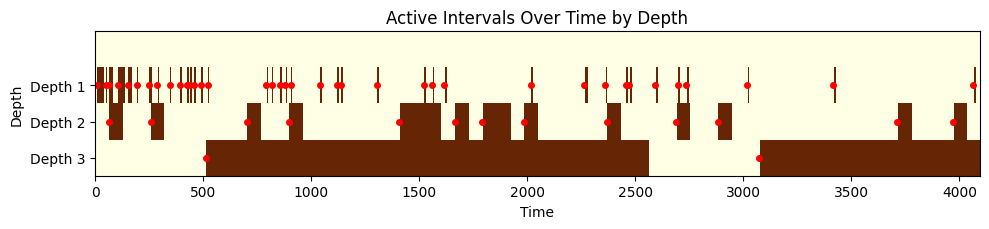

In [37]:
algo.plot_active_mask()

In [40]:
tree = Tree(4)
tree.update_proba()
tree.update_estimates(0.22, 0.60)
tree.visualize_tree()


0.0 1.0
Node(1, 1, False) contains
0.0 0.5
Node(2, 1, False) contains
0.0 0.25
Node(3, 1, False) contains
0.0 0.125
0.125 0.25
Node(4, 2, True) contains
coucou
0.125
0.25 0.5
0.25 0.375
0.375 0.5
0.5 1.0
0.5 0.75
0.5 0.625
0.625 0.75
0.75 1.0
0.75 0.875
0.875 1.0
Tree image saved as dyadic_tree.png


In [50]:
for d, active_nodes in tree.active_depths.items():
    print('d = ', d)
    print('active nodes = ', active_nodes)

d =  4
active nodes =  [Node(4, 1, True), Node(4, 2, True), Node(4, 3, True), Node(4, 4, True), Node(4, 5, True), Node(4, 6, True), Node(4, 7, True), Node(4, 8, True)]
